In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import norm
from scipy import stats
from collections import Counter

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, confusion_matrix, plot_precision_recall_curve

In [ ]:
np.random.seed(203)

In [ ]:
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [ ]:
!unzip 310_23498_bundle_archive.zip

unzip:  cannot find or open 310_23498_bundle_archive.zip, 310_23498_bundle_archive.zip.zip or 310_23498_bundle_archive.zip.ZIP.


In [ ]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
data.shape

(284807, 31)

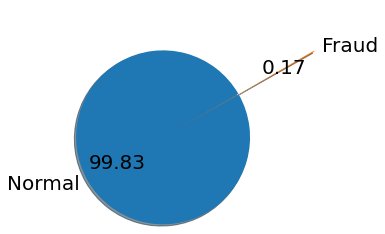

In [ ]:
class_0 = data[data['Class']==0].shape[0]/data.shape[0]
class_fraud = [class_0, (1-class_0)]

plt.pie(class_fraud, explode=(0.5,0.5), labels=['Normal', 'Fraud'], autopct='%.2f', shadow=True, startangle=30)
plt.rc('font', size=20)

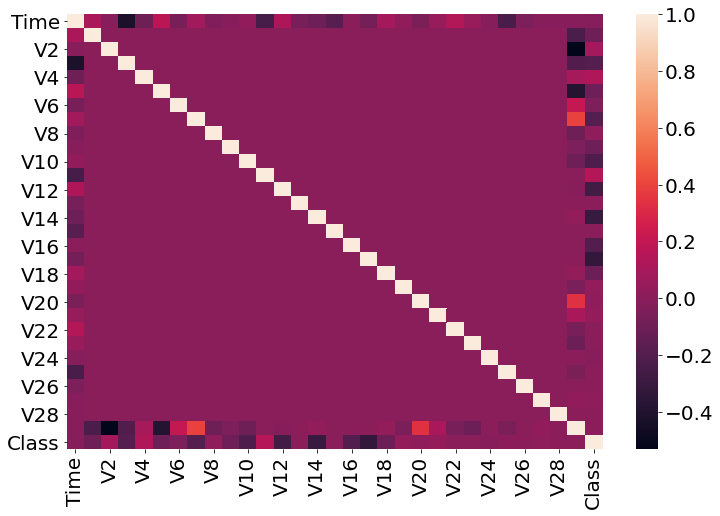

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr())

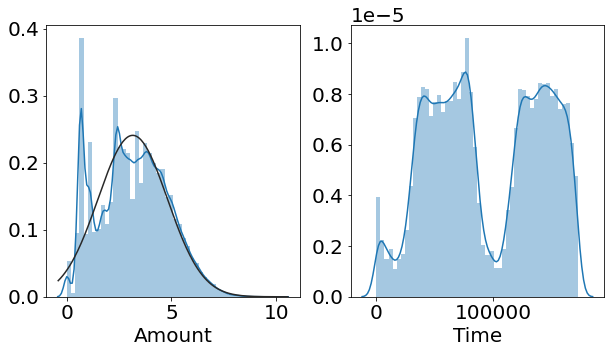

In [ ]:
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(121)
sns.distplot(np.log(data['Amount']+1), fit=norm)

plt.subplot(122)
sns.distplot(data['Time'])

Text(0, 0.5, 'Log-amount')

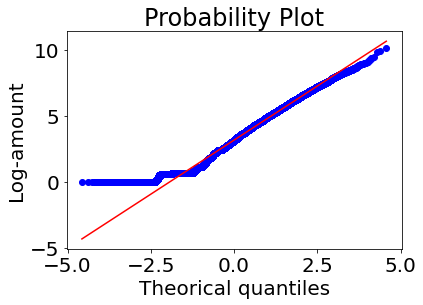

In [ ]:
stats.probplot(np.log(data['Amount']+1), plot=plt)
plt.xlabel('Theorical quantiles', fontsize=20)
plt.ylabel('Log-amount', fontsize=20)

In [ ]:
data[data['Amount']==0]['Class'].value_counts()

0    1798
1      27
Name: Class, dtype: int64

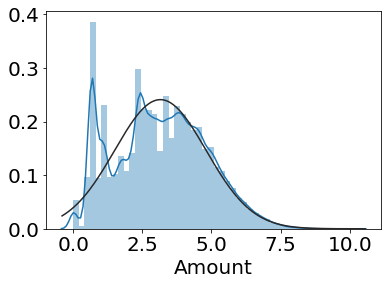

In [ ]:
sns.distplot(np.log(data['Amount']+1), fit=norm)

In [ ]:
df['log_amount'] = np.log(df['Amount']+1)

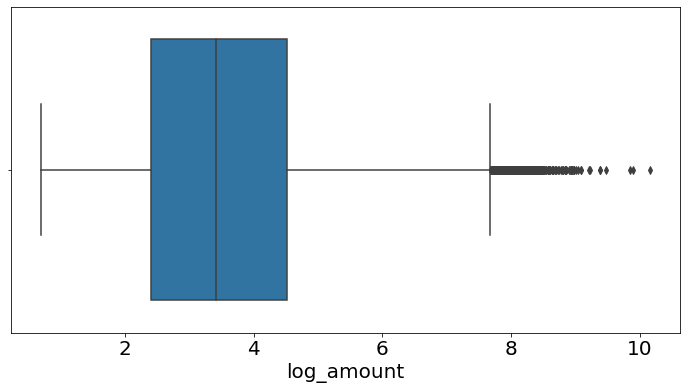

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(df['log_amount'])

In [ ]:
df['log_amount'].describe()

count    254315.000000
mean          3.459793
std           1.478151
min           0.698135
25%           2.396986
50%           3.420673
75%           4.509760
max          10.153941
Name: log_amount, dtype: float64

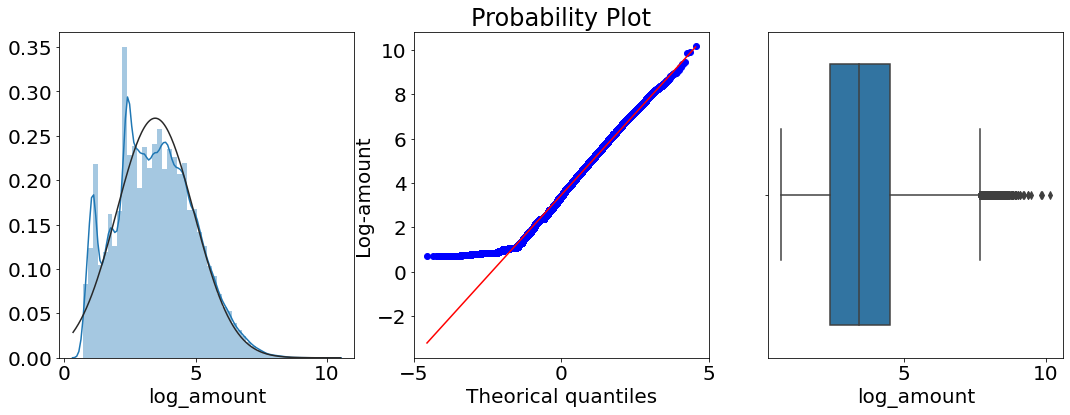

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(131)
sns.distplot(df['log_amount'], fit=norm)

plt.subplot(132)
stats.probplot(df['log_amount'], plot=plt)
plt.xlabel('Theorical quantiles', fontsize=20)
plt.ylabel('Log-amount', fontsize=20)

plt.subplot(133)
sns.boxplot(df['log_amount'])

In [ ]:
df = df.drop(['Time', 'Amount', 'log_amount'], axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,log_amount_scaled,time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.754499,-0.990478
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.001076,-0.990478
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.192083,-0.990466
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.664355,-0.990466
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.398465,-0.990454


## Idea : 
semi-supervised-classification-using-autoencoders
 
#Consider 20000 non-fraud cases vs. total fraud 1.400

In [ ]:
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)

In [ ]:
count_fraud = data['Class'].value_counts().to_frame().reset_index()
count_fraud['percent'] = count_fraud['Class'].apply(lambda x: round(100 * x/len(data), 2))
count_fraud = count_fraud.rename(columns= {'index': 'target', 'Class':'Count'})
count_fraud

,target,Count,percent
0,0,284315,99.83
1,1,492,0.17


In [ ]:
non_fraud = data[data['Class'] == 0].sample(20000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

#Visualize Fraud and NonFraud Transactions

In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    

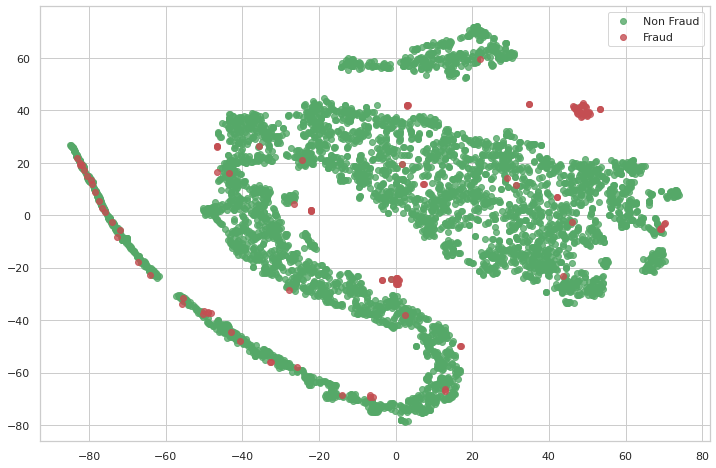

In [ ]:
tsne_plot(X[:5000], Y[:5000], "original.png")

#AutoEncoders

Create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

Create a network with one input layer and one output layer having identical dimentions ie. the shape of non-fraud cases. We will use keras package.

In [ ]:
# input layer
input_layer = Input(shape=(X.shape[1],))

#encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(75, activation='tanh')(encoded)
encoded = Dense(50, activation='relu')(encoded)
encoded = Dense(25, activation='relu')(encoded)

#decoding part 
decoded = Dense(25, activation='tanh')(encoded)
decoded = Dense(50, activation='tanh')(decoded)
decoded = Dense(75, activation='relu')(decoded)
decoded = Dense(100, activation='tanh')(decoded)

#output layer 
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [ ]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
X = data.drop(['Class'], axis=1)
y = data['Class'].values

X_scaled = MinMaxScaler().fit_transform(X.values)
X_norm, X_fraud = X_scaled[y==0], X_scaled[y==1]

Use 30000 rows of non fraud cases to train the autoencoder

In [ ]:
autoencoder.fit(X_norm[0:15000], X_norm[0:15000],
                batch_size=256, epochs=20,
                shuffle=True, validation_split=0.2)

Epoch 1/20
47/47 [==============================] - 0s 7ms/step - loss: 0.2713 - val_loss: 0.2694
Epoch 2/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2684 - val_loss: 0.2664
Epoch 3/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2653 - val_loss: 0.2631
Epoch 4/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2620 - val_loss: 0.2596
Epoch 5/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2583 - val_loss: 0.2559
Epoch 6/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2546 - val_loss: 0.2521
Epoch 7/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2507 - val_loss: 0.2482
Epoch 8/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2467 - val_loss: 0.2443
Epoch 9/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2426 - val_loss: 0.2402
Epoch 10/20
47/47 [==============================] - 0s 4ms/step - loss: 0.2384 - val_loss: 0.2361
Epoch 11/20
47/47 [

In [ ]:
#autoencoder.get_weights()

#Latent Representations

In [ ]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [ ]:
#hidden_representation.get_weights()

Generate the hidden representations of two classes : non-fraud and fraud by predicting the raw inputs using the above model.

#Visualize the latent representations : Fraud Vs Non Fraud

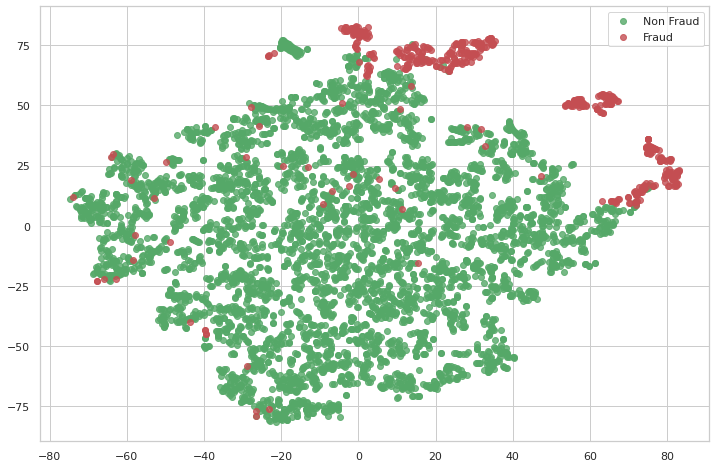

In [ ]:
norm_hid_rep = autoencoder.predict(X_norm[15000:20000])
fraud_hid_rep = autoencoder.predict(X_fraud)
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

#Simple Linear Classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
y_pred = clf.predict(X_test)

print ("")
print ("Classification Report: Train set")
print (classification_report(y_train, clf.predict(X_train)))



Classification Report: Train set
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      3761
         1.0       0.91      0.74      0.82       358

    accuracy                           0.97      4119
   macro avg       0.95      0.87      0.90      4119
weighted avg       0.97      0.97      0.97      4119



In [ ]:
print ("Classification Report: Test set")
print (classification_report(y_test, y_pred))

Classification Report: Test set
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1239
         1.0       0.93      0.77      0.84       134

    accuracy                           0.97      1373
   macro avg       0.95      0.88      0.91      1373
weighted avg       0.97      0.97      0.97      1373



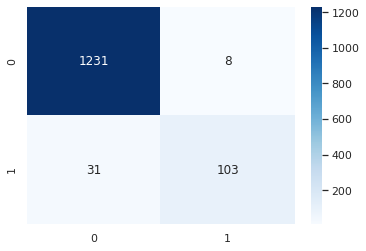

In [ ]:
cm = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

Text(0.5, 1.0, 'Precision-Recall curve')

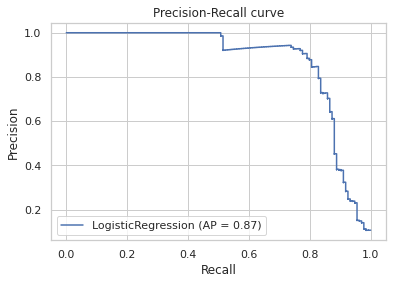

In [ ]:
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve')

In [ ]:
threshold_list = np.arange(0.3, 1.0, 0.1)
for i in threshold_list:
    print('\n***** For threshold = {} *****'.format(i))
    y_test_pred = pd.DataFrame(clf.predict_proba(X_test)).applymap(lambda x: 1 if x>i else 0)
    print(classification_report(y_true=y_test, y_pred=y_test_pred.iloc[:,1]))
    print(confusion_matrix(y_test, y_test_pred.iloc[:,1]))
    print()



***** For threshold = 0.3 *****
              precision    recall  f1-score   support

         0.0       0.99      0.13      0.23      1239
         1.0       0.11      0.99      0.20       134

    accuracy                           0.21      1373
   macro avg       0.55      0.56      0.21      1373
weighted avg       0.90      0.21      0.23      1373

[[ 163 1076]
 [   2  132]]


***** For threshold = 0.4 *****
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      1239
         1.0       0.39      0.89      0.54       134

    accuracy                           0.85      1373
   macro avg       0.69      0.87      0.72      1373
weighted avg       0.93      0.85      0.87      1373

[[1049  190]
 [  15  119]]


***** For threshold = 0.5 *****
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1239
         1.0       0.93      0.77      0.84       134

    accuracy               

Classification report
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91      1239
         1.0       0.39      0.89      0.54       134

    accuracy                           0.85      1373
   macro avg       0.69      0.87      0.72      1373
weighted avg       0.93      0.85      0.87      1373



[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Fraud')]

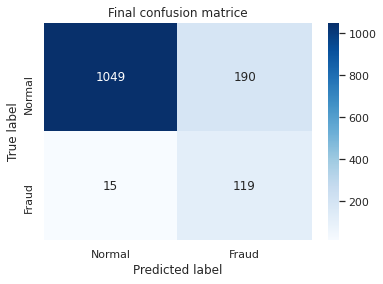

In [ ]:
#Choice : threshold = 0.4 

threshold = 0.4 
y_pred_new = pd.DataFrame(clf.predict_proba(X_test)).applymap(lambda x: 1 if x>threshold else 0).iloc[:,1]

print('Classification report')
print(classification_report(y_test, y_pred_new))

cm = confusion_matrix(y_test, y_pred_new)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Final confusion matrice')
plt.xlabel('Predicted label')
ax.set_xticklabels(labels=['Normal', 'Fraud'])
plt.ylabel('True label')
ax.set_yticklabels(labels=['Normal', 'Fraud'])

The choice of decision threshold is important in treament of imbalanced data, especially in case of fraud detection. 